In [24]:
### Import Libraries ###

# Pandas for managing datasets
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

# Numpy, Statistics and Random for math
import numpy as np
import random as rand
import statistics
import scipy.signal

# Warnings to remove complex to real conversion warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn for Machine Learning
import sklearn
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# SoundFile to for opening raw audio files
import soundfile as sf

# Collections for circular arrays
import collections

# Librosa for Audio Processing
import librosa

In [25]:
### Define Functions ###

# Function to load a raw audio file and return all of the audio channels averaged together
def getAudioData(filename, samplerate):
    data_type = filename.split('.')[1]
    print(filename)
    sig = []
    sr = 0
    
    if data_type == 'raw':
        # Load Raw Audio Data into [sig] and [sr]
        sig, sr = sf.read(filename, channels=2, samplerate=62500, format='RAW', subtype='PCM_16')
    else:
        sig, sr = sf.read(filename)

    # Define an empty array to store the combined audio channels
    data = []

    # Average the left and right audio channels and store in [data]
    ##print len(returnShape(sig[0]))
    if len(returnShape(sig[0]))>0:
        for i in range(0, len(sig)):
            average = (sig[i][0]+sig[i][1])/2
            data.append(average)
    else:
        data = sig
    return data

# Function to clean a pandas dataset
def clean_dataset(df):
    return df.replace([np.inf, -np.inf, np.nan], 0)

# Function to get the shape of an object
def returnShape(*args):
    return np.broadcast(*args).shape

# Function to calculate the label for a window
def calculateLabel(labels):
    total = sum(labels)
    num = len(labels)
    if total/num > 0.4:
        return 1
    else:
        return 0

# Function to split a Pandas DataFrame into equal size parts based on [chunkSize]
def splitDataFrameIntoSmaller(df, chunkSize = 10000):
    chunkSize = int(chunkSize)
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(int(numberChunks)):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

# Function to convert a complex number to a real number
def convertToReal(c):
    return (c.real**2)+(c.imag**2)

def remap(array,start,end):
    array = list(map(np.float64, array))
    size = abs(max(array)-min(array))
    new_size = abs(start-end)
    scalar = new_size/size
    scaled = np.multiply(array, scalar)
    offset = start-min(scaled)
    transformed = np.add(scaled, offset)
    return transformed

# Function to calculate the mean value of an array
def mean(array):
    return np.mean(array, dtype=np.float64)

# Function to calculate the median value of an array
def median(array):
    return np.median(array)

def splitFunc(sig,func):
    upper = []
    lower = []
    for i in range(0, len(sig)):
        if sig[i] >= 0:
            upper.append(sig[i])
            lower.append(0)
        else:
            lower.append(sig[i])
            upper.append(0)
    lower_inv = np.multiply(lower, -1)
    func_upper = func(upper)
    func_lower = func(lower_inv)
    func_lower_inv = np.multiply(func_lower, -1)
    
    return np.add(func_upper, func_lower_inv)

# Function to calculate the Fast Fourier Transform of an array
def FFT(array):
    fft = np.fft.fft(array)
    return [f for f in fft if (f <= 8000)]

# Function to calculate the mean value of the FFT of an array
def meanFFT(array):
    fft = FFT(array)
    return convertToReal(mean(fft))

# Function to calculate the median value of the FFT of an array
def medianFFT(array):
    fft = FFT(array)
    return convertToReal(median(fft))

# Function to calculate the maximum value of the FFT of an array
def maxFFT(array):
    fft = FFT(array)
    return convertToReal(max(fft))

# Function to calculate the minimum value of the FFT of an array
def minFFT(array):
    fft = FFT(array)
    return convertToReal(min(fft))

# Function to calculate the sum of the FFT of an array
def sumFFT(array):
    fft = FFT(array)
    return convertToReal(sum(fft))

# Function to calculate the standard deviation of the FFT of an array
def stdevFFT(array):
    fft = FFT(array)
    return statistics.stdev(list(map(convertToReal, fft)))

def MFCC(y, sr, n_mfcc):
    y = np.array(map(np.float64,y))
    mfccs = np.array(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc))
    mfcc_sum = np.array([0]*len(mfccs[0]))
    for i in range(0, len(mfccs)):
        if i < 5:
            normalized = remap(mfccs[i],0.000001,1.0)
            mfcc_sum = np.add(mfcc_sum,np.power(normalized,7))        
    return sum(mfcc_sum)

def winSizeToSeconds(winSize, sampling_rate):
    winSize = float(winSize)
    sampling_rate = float(sampling_rate)
    one = 1/sampling_rate
    return one*winSize

def runningAverage(average, value, counter, factor):
    counter = float(counter)
    factor = float(factor)
    average = average + (value - average) / min(counter, factor)
    return average

def invert(num):
    if num == 0:
        return 1
    if num == 1:
        return 0
    return num

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

In [26]:
### Define Starting Variables ###

## windowSizes = list(np.arange(300, 9001, 300))
windowSizes = list(np.arange(20, 40, 2))
windowSizes = np.divide(map(float, windowSizes), 1000)
print(windowSizes)

NUM_FILES = len(pd.read_csv('DataLoc.csv').values)
print('Num Files: '+str(NUM_FILES))

[0.02  0.022 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038]
Num Files: 48


In [20]:
### Open the Raw Audio Files, Convert them to .csv Files and Label them ###

# Open the .csv that information about the audio files # signed 8 bit pcm 62500 hz
data_loc = pd.read_csv('DataLoc.csv').values

# Define an empty array [audio_data] to store the data from the raw audio files
audio_data = []

# Loop through all of the lines in [data_loc] (One for each file)
for i in range(0, len(data_loc)):
    sampling_rate = data_loc[i][3]
    
    # Store the audio data in [audio_sig]
    audio_sig = getAudioData(data_loc[i][2],sampling_rate)
    
    # Generate arrays of ones and zeroes equal to length of speaking and not speaking
    starting_silence = [0]*data_loc[i][0]
    speaking = [1]*(data_loc[i][1]-data_loc[i][0])
    ending_silence = [0]*(len(audio_sig) - data_loc[i][1])
    
    # Combine the arrays into one larger array
    labels = starting_silence+speaking+ending_silence
    
    # Append the [audio_sig] and [labels] to [audio_data]
    audio_data.append([audio_sig, labels, sampling_rate])
    
# Loop through each item in [audio_data]
for i in range(0, len(audio_data)):
    
    # Save each line of the file into a .csv file
    with open(str(i)+'.csv', 'a+') as csv:
        csv.seek(0)
        csv.truncate()
        
        # Write the header
        csv.write('sig,label,fileID,sampling_rate\n')
        
        # Loop through each line and write the signal and label
        for j in range(0, len(audio_data[i][0])):
            ## print(returnShape(audio_data[i]))
            sig = str(audio_data[i][0][j])
            label = str(audio_data[i][1][j])
            sampling_rate = str(audio_data[i][2])
            csv.write(sig+','+label+','+str(i)+','+sampling_rate+'\n')
            
print('Converted all raw audio file to csv\'s and labeled them')

Adobe1.raw
Adobe2.raw
Adobe3.raw
Adobe4.raw
Adobe5.raw
Photoshop1.raw
Photoshop2.raw
Photoshop3.raw
Photoshop4.raw
Photoshop5.raw
Lightroom1.raw
Lightroom2.raw
Lightroom3.raw
Lightroom4.raw
Lightroom5.raw
WhooHoo1.raw
WhooHoo2.raw
WhooHoo3.raw
WhooHoo4.raw
WhooHoo5.raw
AdobeAudioSamples/REF-US_ENGLISH-000-ADOBE.wav
AdobeAudioSamples/REF-US_ENGLISH-000-LIGHTROOM.wav
AdobeAudioSamples/REF-US_ENGLISH-000-PHOTOSHOP.wav
AdobeAudioSamples/REF-US_ENGLISH-000-WOOHOO.wav
AdobeAudioSamples/REF-US_ENGLISH-001-ADOBE.wav
AdobeAudioSamples/REF-US_ENGLISH-001-LIGHTROOM.wav
AdobeAudioSamples/REF-US_ENGLISH-001-PHOTOSHOP.wav
AdobeAudioSamples/REF-US_ENGLISH-001-WOOHOO.wav
AdobeAudioSamples/REF-US_ENGLISH-002-ADOBE.wav
AdobeAudioSamples/REF-US_ENGLISH-002-LIGHTROOM.wav
AdobeAudioSamples/REF-US_ENGLISH-002-PHOTOSHOP.wav
AdobeAudioSamples/REF-US_ENGLISH-002-WOOHOO.wav
AdobeAudioSamples/REF-US_ENGLISH-003-ADOBE.wav
AdobeAudioSamples/REF-US_ENGLISH-003-LIGHTROOM.wav
AdobeAudioSamples/REF-US_ENGLISH-003-PHOT

In [27]:
## Load the Labeled .csv Files into [windows] ###
windows = []
for i in range(0, NUM_FILES):
    windows.append(pd.read_csv(str(i)+'.csv'))
print('Loaded '+str(NUM_FILES)+' data files')

Loaded 48 data files


In [38]:
### Calculate the Features for each Window Size ###

# Define an empty array to store the features
features = []

## Loop through all of the window sizes and data, calculate the feater and append it to features ##

# Loop through [windows] (An array storing each of the .csv files)
for i in range(0, len(windows)):
    print('Calculating Data for file: '+str(i))
    sr = windows[i].values[0][3]
    # Loop through all of the [windowSizes]
    for j in range(0, len(windowSizes)):
        print('Calculating Data for window size: '+str(windowSizes[j]))
        # Split [windows{i}] into parts based on the current [windowSize]
        data = splitDataFrameIntoSmaller(windows[i], windowSizes[j]*sr)
        # Loop through every line in data
        for k in range(0, len(data)-1):
            # Store the current windowSize, audio signal, label, and fileID
            windowSize = float(windowSizes[j])
            sig = list(map(float, data[k]['sig']))
            smoothed = splitFunc(sig,np.sqrt)
            label = calculateLabel(data[k]['label'].values)
            ID = median(data[k]['fileID'].values)
            ## print(ID)
            
            # Append the fileID, windowSize, all of the features, and label to [features]
            features.append([ID, windowSize, mean(sig), median(sig), min(sig), 
                             max(sig), sum(sig),statistics.stdev(sig),
                             meanFFT(smoothed), medianFFT(smoothed), minFFT(smoothed),
                             maxFFT(smoothed), sumFFT(smoothed), stdevFFT(smoothed), MFCC(sig,sr,4),label])
# Convert [features] to a DataFrame and store it in [dataFrame]
dataFrame = pd.DataFrame(data=features)
# Set [dataFrame]'s columns
dataFrame.columns = ['fileID','windowSize','mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT','mfcc','label']
# Save [dataFrame] as "Windows.csv"
dataFrame.to_csv('Windows.csv', sep=',', index=False)
print('Calculated all features over all window sizes and save to a file')


Calculating Data for file: 0
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 1
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 2
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.02

Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 20
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 21
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for win

Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 39
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for window size: 0.034
Calculating Data for window size: 0.036
Calculating Data for window size: 0.038
Calculating Data for file: 40
Calculating Data for window size: 0.02
Calculating Data for window size: 0.022
Calculating Data for window size: 0.024
Calculating Data for window size: 0.026
Calculating Data for window size: 0.028
Calculating Data for window size: 0.03
Calculating Data for window size: 0.032
Calculating Data for wind

In [28]:
### Pick a random file to always train on and define an array storing all of the files ###
file_num = np.arange(0, NUM_FILES)
items = rand.sample(file_num, 15)
print('Picked random file to leave out: '+str(items))

Picked random file to leave out: [37, 24, 11, 9, 42, 6, 27, 34, 25, 13, 38, 44, 14, 32, 39]


In [30]:
### Train and Test the data on each Window Size ###
data = pd.read_csv('Windows.csv')
data = clean_dataset(data)

ws = data.filter(items=['windowSize']).values.ravel()
ws = [round(w,3) for w in ws]
data['windowSize'] = ws

## print ws
## print data.columns
## print data.head()
dataColumns = ['mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT','mfcc']

print('### Confusion Matrix for each Window Size ###')
print('        (Window Sizes are in seconds)')

# Define empty arrays to store the machine learning result 
matrix = []
chart = []
zero_r_y = []
one_r_y = []
one_r_features = []

# Define int to store the sampling rate
sampling_rate = 62500

# Loop through all window Sizes
for i in range(0, len(windowSizes)):
    ## print('i')
    ## print(i)
    # Define variables to store the mean accuracy, and the current window size
    mean_acc = []
    windowSize = round(windowSizes[i],3)
    mean_one_r = []
    
    # Loop through all of the randomly chosen files
    for j in range(0, len(file_num)):
        # Define vairable to store the 2 query strings and store the confusion matrix
        string = '('
        string2 = '('
        
        conf_matrix = [0]*4
        
        # Loop through all of the randomly chosen files and update the query strings
        for k in range(0, len(file_num)):
            if  (file_num[k]  in items) or k == j:
                string2 += 'fileID=='+str(file_num[k])+' or '
            else:
                string += 'fileID=='+str(file_num[k])+' or '
        
        # Finish editing the query strings
        string = string[:-3] + ') and windowSize=='+str(windowSize)
        string2 = string2[:-3]+') and windowSize=='+str(windowSize)
        ## print (string,string2)
        
        # Use the query strings to genereate train and test, data and values
        trainDataValues = data.query(string).filter(items=dataColumns)
        trainLabels = data.query(string).filter(items=['label'])
        testDataValues = data.query(string2).filter(items=dataColumns)
        testLabels = data.query(string2).filter(items=['label'])
        
        # Initilize Classifiers
        ## mnb = GaussianNB()
        mnb = RandomForestClassifier(n_estimators=500, max_depth=7)
        ## mnb = tree.DecisionTreeClassifier(max_depth=5)
        
        # Train and predict the model
        mnb.fit(trainDataValues, trainLabels)
        predicted = mnb.predict(testDataValues)
        
        # Store the accuracy in [fold], [mean] and [matrix]
        fold = metrics.accuracy_score(testLabels,predicted)
        mean_acc.append(fold)
        matrix.append([windowSize,fold,file_num[j]])
        
        # Store the confusion matrix in [conf_matrix]
        conf_matrix = np.add(conf_matrix, metrics.confusion_matrix(testLabels, predicted).ravel())
        
        ## Calculate Zero R ##
        best_clf = None
        best_accuracy = 0
        best_feature = 0
        for i in range(0, len(dataColumns)):
            feature = dataColumns[i]
            ## print feature
            clf = tree.DecisionTreeClassifier(max_depth=1)
            clf.fit(trainDataValues.filter(items=[feature]), trainLabels)
            predicted = clf.predict(testDataValues.filter(items=[feature]))
            accuracy = metrics.accuracy_score(testLabels,predicted)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_clf = clf   
                best_feature = feature
        one_r_features.append(i)
        mean_one_r.append(accuracy)
    
    # Print the averaged confusion matrix from the inner loop
    print('Window Size '+str(windowSize)+': '+str(map(float, np.divide(conf_matrix, float(len(file_num))))))
    
    # Append the [windowSize] and mean accuracy to chart
    chart.append([windowSize,np.mean(mean_acc)])
    
    ## Calcuate Zero R ##
    
    # Store the number of windows for the current iterations in [length]
    length = data.query('windowSize == '+str(windowSize)).shape[0]
    # Store the number of windows (Of the current [windowSize]) for which there was no talking in [not_talking]
    not_talking = data.query('windowSize == '+str(windowSize)+' and label == 0').shape[0]
    # Store the Zero R accuracy in [acc]
    acc = float(not_talking)/length
    # Append [acc] to [zero_r_y]
    zero_r_y.append(acc)
    
    one_r_y.append(np.mean(mean_one_r))
    
# Convert [matrix] to a DataFrame
matrix = pd.DataFrame(matrix, columns=['windowSize','accuracy','fileID'])
# Save [matrix] as a .csv
matrix.to_csv('windowResults.csv', sep=',', index=False)

# Convert [chart] to a DataFrame
chart = pd.DataFrame(chart, columns=['windowSize','accuracy'])

print('Calculated: Zero R, One R and trained RandomForestClassifier for each window size')

### Confusion Matrix for each Window Size ###
        (Window Sizes are in seconds)
Window Size 0.02: [3.5208333333333335, 0.4791666666666667, 1.2708333333333333, 9.166666666666666]
Window Size 0.022: [3.3958333333333335, 0.2916666666666667, 1.1041666666666667, 8.333333333333334]
Window Size 0.024: [3.0208333333333335, 0.4375, 0.875, 7.729166666666667]
Window Size 0.026: [2.7708333333333335, 0.3958333333333333, 0.7708333333333334, 7.166666666666667]
Window Size 0.028: [2.4583333333333335, 0.5, 0.625, 6.6875]
Window Size 0.03: [2.4583333333333335, 0.22916666666666666, 1.0625, 5.8125]
Window Size 0.032: [2.3125, 0.2708333333333333, 0.6458333333333334, 5.770833333333333]
Window Size 0.034: [2.0625, 0.3958333333333333, 0.6458333333333334, 5.270833333333333]
Window Size 0.036: [2.125, 0.20833333333333334, 0.8333333333333334, 4.833333333333333]
Window Size 0.038: [2.0, 0.22916666666666666, 0.6666666666666666, 4.645833333333333]
Calculated: Zero R, One R and trained RandomForestClassifier for

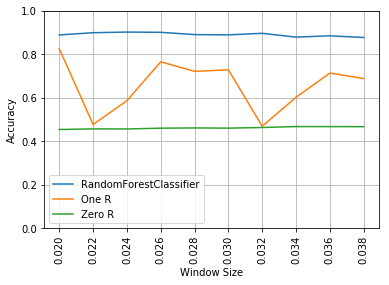

Best Accuracy:
0.9024256280286508

Most Influential Feature (One R):
mfcc


In [31]:
y = chart['accuracy']
x = chart['windowSize']

rfc = plt.plot(x, y, label='RandomForestClassifier')
one_r = plt.plot(x, one_r_y, label='One R')
zero_r = plt.plot(x, zero_r_y, label='Zero R')

label_location = [0]+windowSizes
plt.xticks(label_location, rotation='vertical')
plt.grid()
plt.ylim(0, 1)
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Best Accuracy:')
print(max(chart['accuracy'].values))
print('\nMost Influential Feature (One R):')
print(dataColumns[int(np.median(one_r_features))])

In [39]:
### Predict Labels for a Test Data File ###

WIN_SIZE = 0.03

# Open the calculated features and clean the dataset
test = pd.read_csv('Windows.csv')
test = clean_dataset(test)

ws = test.filter(items=['windowSize']).values.ravel()
ws = [round(w,3) for w in ws]
test['windowSize'] = ws

## print test.shape

# Filter out uneeded columns and only keep a windowSize of [WIN_SIZE]
dataColumns = ['mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT','mfcc']
trainDataValues = test.query('windowSize=='+str(WIN_SIZE)).filter(items=dataColumns)
trainLabels = test.query('windowSize=='+str(WIN_SIZE)).filter(items=['label'])
print('Got Data')

# Create and Train a RandomForestClassifier
mnb = RandomForestClassifier(n_estimators=200, max_depth=5)
mnb.fit(trainDataValues, trainLabels)
print('Trained Model')

sigs = pd.read_csv('Test.csv').filter(items=['sig'])
lbl = np.array_split(sigs.values, WIN_SIZE*62500)
lbl = [lb.tolist() for lb in lbl]
lbl = [[l[0] for l in lb] for lb in lbl]


features = []
for i in range(0, len(lbl)):
    sig = lbl[i]
    smooth = splitFunc(sig,np.sqrt)
    features.append([mean(sig), median(sig), min(sig), max(sig), sum(sig), statistics.stdev(sig), 
                     meanFFT(smooth), medianFFT(smooth), minFFT(smooth), maxFFT(smooth), 
                     sumFFT(smooth), stdevFFT(smooth), MFCC(sig,62500,12)])
print('Calculated Features')
labels = []
raw_labels = []
c = collections.deque(maxlen=10)
for i in range(0, len(features)):
    featuresdf = pd.DataFrame(data=[features[i]])
    feature = clean_dataset(featuresdf).values
    label = mnb.predict(feature)
    raw_labels.append(label)
    c.append(label*5)
    labels.append(calculateLabel(list(c)))
    
# Store the first and last predicted speaking in variables
first_detection = next((index for index,value in enumerate(raw_labels) if value != 0), None)
last_detection = (len(raw_labels)-1)-next((index for index,value in enumerate(reversed(raw_labels)) if value != 0), None)
## print(first_detection, last_detection)
filtered_labels = ([0]*first_detection)+([0.5]*(last_detection-first_detection))+([0]*(len(raw_labels)-last_detection))
pd.DataFrame(labels).to_csv('lbl.csv')
pd.DataFrame(raw_labels).to_csv('lbl2.csv')
pd.DataFrame(filtered_labels).to_csv('lbl3.csv')
print('Saved Predicted Labels')


Got Data
Trained Model
Calculated features
Saved Predicted Labels


In [35]:
### Real-Time Detection ###

# Import libraries
from __future__ import print_function
import pyaudio
import sys
import time

# Define global vairables
FORMAT = pyaudio.paInt8
CHANNELS = 1
RATE = 48000
WIN_SIZE = 0.03

# Create a PyAudio Object
audio = pyaudio.PyAudio()

# Get the microphone
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE, 
                    input=True,
                    frames_per_buffer=int(WIN_SIZE*RATE))

# Open the calculated features and clean the dataset
test = pd.read_csv('Windows.csv')
test = clean_dataset(test)

# Filter out uneeded columns and only keep a windowSize of [WIN_SIZE]
dataColumns = ['mean','median','min','max','sum','stdev','meanFFT','medianFFT','minFFT','maxFFT','sumFFT','stdevFFT','mfcc']
trainDataValues = test.query('windowSize=='+str(WIN_SIZE)).filter(items=dataColumns)
trainLabels = test.query('windowSize=='+str(WIN_SIZE)).filter(items=['label'])
print('Got Data')

# Create and Train a RandomForestClassifier
mnb = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
mnb.fit(trainDataValues, trainLabels)
print('Trained Model')

## # Get data from the microphone
## sig = np.fromstring(stream.read(CHUNK, exception_on_overflow = False), np.int16)
## print mnb.predict([[mean(sig),median(sig),min(sig),max(sig),sum(sig),statistics.stdev(sig),
##                     meanFFT(sig),medianFFT(sig),minFFT(sig),maxFFT(sig),sumFFT(sig),stdevFFT(sig)]])

#avg = 0
factor = 10
weight = 5
#N = 1
c = collections.deque(maxlen=factor)
c.append(0)

prev = 0
print('Starting Realtime Predictions')
while True:
    try:
        # Get Data From the microphone
        samples = int(WIN_SIZE*RATE)
        sig = np.fromstring(stream.read(samples, exception_on_overflow=False), np.int16)
        sig = np.divide(sig, 64)
        ## print(sig)
        smooth = splitFunc(sig,np.sqrt)
        # Calulate all of the features over that data
        features = [mean(sig),median(sig),min(sig),max(sig),sum(sig),statistics.stdev(sig),
                    meanFFT(smooth),medianFFT(smooth),minFFT(smooth),maxFFT(smooth),
                    sumFFT(smooth),stdevFFT(smooth),MFCC(sig,RATE,4)]
        
        features = np.nan_to_num(features)

        # Make a detection based on those features
        prediction = mnb.predict([features])[0]
        
        c.append(prediction*weight)
        #avg = int(runningAverage(avg, prediction, N, factor))
        pred = calculateLabel(list(c))            
        # Overwrite the previous print out with the new detection
        #print(avg, end='\r')
        print('Prediction: '+str(c), end='\r')
        sys.stdout.flush()
        if prev == 0 and pred ==1:
            #print(list(c), end='\r')
            prev = 1
            #time.sleep(1)
        if pred == 0:
            prev = 0
 
        
        #N = N + 1
            
    # If there is a ~KeyboardInterrupt~ close all of the audio objects
    except KeyboardInterrupt:
        stream.stop_stream()
        stream.close()
        audio.terminate()
        sys.stdout.flush()
        print('Closed Audio')

Got Data
Trained Model
Starting Realtime Predictions
Closed Audiodeque([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=10)


IOError: [Errno -9988] Stream closed

[21, 22.0, 22.0, 22.0, 22.0, 22.0, 22.333333333333332, 22.555555555555554, 22.703703703703702, 22.80246913580247, 22.868312757201647, 21.578875171467764, 20.719250114311844, 20.146166742874563, 19.764111161916375, 19.509407441277585, 17.672938294185055, 16.448625529456702, 15.632417019637801, 15.088278013091868, 14.725518675394579, 17.150345783596386, 18.766897189064256, 19.844598126042836, 20.56306541736189, 21.042043611574595]


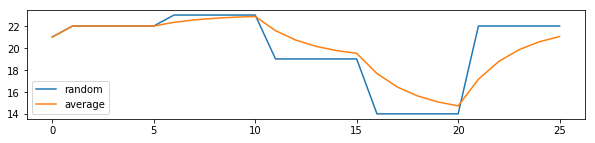

In [114]:
### Test Running Average ###

import random

max_value = 40
min_value = 0
num_samples = 5
iterations = 5
factor = 3
N = 1
y = [random.randint(min_value, max_value)]
y2 = [y[0]]

for i in range(0, num_samples):
    new_sample = random.randint(min_value, max_value)

    for j in range(0, iterations):
        y2.append(new_sample)
        new_avg = runningAverage(y[-1], new_sample, N, factor)
        y.append(new_avg)
        N += 1

print(y)
x = np.arange(0, len(y))

plt.figure(figsize=(10,2))
plt.plot(x, y2, label='random')
plt.plot(x, y, label='average')
plt.legend()
plt.show()

In [ ]:
#abs,log,power,mfcc,cutoff above 8khz